# Budget allocation proposal

### Pseudo-Revenue, First-Revenue assumption
### Regressions

In [1]:
import pandas as pd
import numpy as np
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 5]

validDf = pd.read_csv("../data/valid_dataset_minimal.csv").drop(columns=["Unnamed: 0"])
campaigns = validDf["Campaign"].unique()
validDf["Date"] = pd.to_datetime(validDf["Date"])
# print(validDf.head(10))
print(validDf.dtypes)

Date                     datetime64[ns]
Source / Medium                  object
Campaign                         object
Device Category                  object
Users                             int64
Sessions                          int64
Bounces                           int64
Transactions                      int64
Cost                            float64
Revenue                         float64
Product Detail Views              int64
Product Adds To Cart              int64
Product Checkouts                 int64
Session Duration                 object
Total Unique Searches             int64
Pageviews                        object
New Users                         int64
Session Duration (s)            float64
Medium                           object
dtype: object


In [2]:
from ipynb.fs.defs.nb3 import getDataFirstRevenueCampaign, getDataFirstRevenue

X, t = getDataFirstRevenue(validDf, features=["Cost"])

Campaign: AW - Accessories. Shapes: (452,) (452, 1) object float64
Campaign: AW - Apparel. Shapes: (138,) (138, 1) object float64
Campaign: AW - Dynamic Search Ads Whole Site. Shapes: (382,) (382, 1) object float64
Campaign: AW - Bags. Shapes: (52,) (52, 1) object float64
Campaign: AW - Google Brand. Shapes: (56,) (56, 1) object float64
Campaign: AW - Office. Shapes: (36,) (36, 1) object float64
Campaign: All Products. Shapes: (109,) (109, 1) object float64


### 2.3 Linear Regression

For Linear Regression we've got the problem that the training data and the testing data is not from the same distribution.

Basically, the problem is that we are training on Data: $X=\sum(Costs)$ and Labels: $t=Revenue$, however, when we are using the model, we are generating from the distribution Data: $X=Cost$, PseudoRevenue: $y=f(X)$.

The problem can be the simplest explained as: $a * f(x_1 + x_2) + b != [a * f(x_1) + b] + [a * f(x_2) + b] $.

However, we can always pre-split our data in first-revenue assumption AND linear time assumption (see proposal), basically instead of having $X=\sum_n(Costs)$, $t=Revenue$, we can have $X=[Cost_1, ..., Cost_n]$, $t=[\frac{Revenue}{Cost_1}, ..., \frac{Revenue}{Cost_n}]$. 

If we were to not use a linear time assumption, we'd have a non-linear ponder $t=[\frac{Revenue}{Cost_1}*w_1, ..., \frac{Revenue}{Cost_n}*w_n]$, where $w_i$ is somehow dependant on time (separate model or such).

#### 2.3.1 Dataset creation

In [3]:
XLinearRegression, tLinearRegression, Mappings = {}, {}, {}

def getDataLR(X, t):
    Mappings, XRes, tRes = [], [], []
    N = len(X)
    for i in range(N):
        XRes.extend(list(X[i]))
        tRes.extend(list(t[i] / X[i]))
        Mappings.extend([i] * len(X[i]))
    return np.array(XRes).reshape((-1, 1)), np.array(tRes).reshape((-1, 1)), np.array(Mappings)
                                                                    
for k in X:
    XLinearRegression[k], tLinearRegression[k], Mappings[k] = getDataLR(X[k], t[k])
    print(k, XLinearRegression[k].shape, tLinearRegression[k].shape, Mappings[k].shape)

AW - Accessories (2090, 1) (2090, 1) (2090,)
AW - Apparel (1678, 1) (1678, 1) (1678,)
AW - Dynamic Search Ads Whole Site (1954, 1) (1954, 1) (1954,)
AW - Bags (633, 1) (633, 1) (633,)
AW - Google Brand (926, 1) (926, 1) (926,)
AW - Office (551, 1) (551, 1) (551,)
All Products (449, 1) (449, 1) (449,)


#### 2.3.2 Train model.

In [4]:
from ipynb.fs.defs.nb3 import KFold, errorL1

def trainModelLR(X, t, Mappings, modelType, numSplits, randomState):
    kf = KFold(numSplits=numSplits, randomState=randomState)
    errors = []
    Max = Mappings.max()
    ix = np.arange(Max)
    for trainIx, validationIx in kf.split(Max):
        model = modelType()
        trainMap, valMap = ix[trainIx], ix[validationIx]
        whereTrain = np.isin(Mappings, trainMap)
        whereVal = np.isin(Mappings, valMap)
        model.fit(X[whereTrain], t[whereTrain])
        y = model.predict(X[whereVal])
        errors.append(errorL1(y, t[whereVal]))

    # We report the mean error on all K-fold splits for robustness
    meanError = np.mean(errors)
    
    # Then, we retrain on all data, for best test/future predictions
    model = modelType()
    model.fit(X, t)
    return model, meanError

def trainAllCampaignsLR(df, X, t, modelType, columns, XXs, numSplits, randomState):
    models, errors = {}, {}
    validCampaigns = list(X.keys())
    df = df.copy()

    for i, campaign in enumerate(validCampaigns):
        thisT = np.clip(t[campaign], 0, np.percentile(t[campaign], XXs[campaign]))
        model, error = trainModelLR(X[campaign], thisT, Mappings[campaign], modelType, numSplits, randomState)
        dfCampaign = df[df["Campaign"] == campaign]
        pseudo = model.predict(dfCampaign[columns].values)
        error = dfCampaign["Revenue"].sum() - pseudo.sum()
        models[campaign] = model
        errors[campaign] = error
    return models, errors

def getOptimalThresholds(df, X, t, modelType, columns, numSplits, randomState):
    XXs = {}
    validCampaigns = list(X.keys())
#     Optimize threshold for all campaigns to remove outliers.
    for i, campaign in enumerate(validCampaigns):
        res = []
        for i in range(100):
            thisT = np.clip(t[campaign], 0, np.percentile(t[campaign], i))
            model, error = trainModelLR(X[campaign], thisT, Mappings[campaign], modelType, numSplits, randomState)
            dfCampaign = df[df["Campaign"] == campaign].copy()
            dfCampaign["Pseudo Revenue"] = model.predict(dfCampaign[columns])
            error = np.abs(dfCampaign["Revenue"].sum() - dfCampaign["Pseudo Revenue"].sum())
            res.append(error)
        XXs[campaign] = np.argmin(res)
    return XXs

First, optimize threshold for each campaign, then use best one to get best model.

In [5]:
from sklearn.linear_model import LinearRegression
LR = partial(LinearRegression, fit_intercept=False, normalize=True)
XXs = getOptimalThresholds(validDf, XLinearRegression, tLinearRegression, LR, columns=["Cost"], numSplits=5, randomState=42)
print(XXs)

{'AW - Accessories': 99, 'AW - Apparel': 89, 'AW - Dynamic Search Ads Whole Site': 99, 'AW - Bags': 58, 'AW - Google Brand': 58, 'AW - Office': 46, 'All Products': 99}


In [6]:
LRModels, LRErrors = trainAllCampaignsLR(validDf, XLinearRegression, tLinearRegression, LR, columns=["Cost"], XXs=XXs, numSplits=5, randomState=42)
display(pd.DataFrame([(x, y) for x, y in zip(LRErrors.keys(), LRErrors.values())], columns=["Campaign", "Best error (L1)"]))

,Campaign,Best error (L1)
0,AW - Accessories,51415.407245
1,AW - Apparel,62.739818
2,AW - Dynamic Search Ads Whole Site,37550.422273
3,AW - Bags,33.813005
4,AW - Google Brand,10.170680
5,AW - Office,-27.922767
6,All Products,966.978175


In [7]:
from ipynb.fs.defs.nb3 import createPseudoRevenues
LRFinalDf = createPseudoRevenues(LRModels, validDf, features=["Cost"])
print(LRFinalDf.shape, LRFinalDf.columns)

(8281, 20) Index(['Date', 'Source / Medium', 'Campaign', 'Device Category', 'Users',
       'Sessions', 'Bounces', 'Transactions', 'Cost', 'Revenue',
       'Product Detail Views', 'Product Adds To Cart', 'Product Checkouts',
       'Session Duration', 'Total Unique Searches', 'Pageviews', 'New Users',
       'Session Duration (s)', 'Medium', 'Pseudo Revenue'],
      dtype='object')


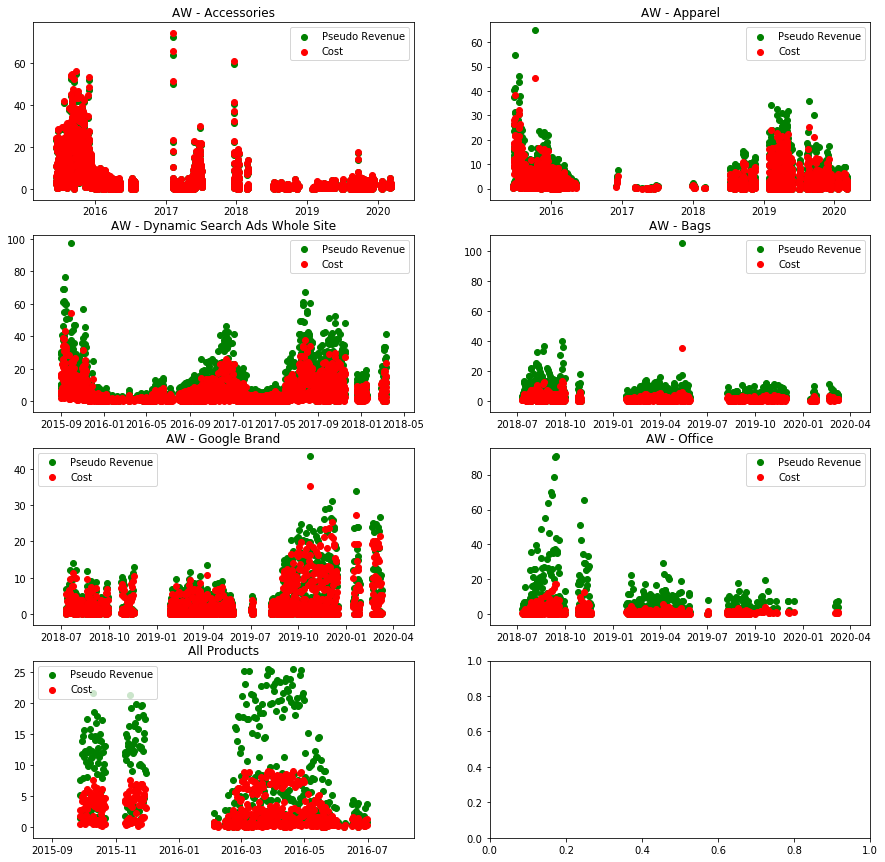

In [8]:
from ipynb.fs.defs.nb3 import plotRevenues
plotRevenues(LRFinalDf)

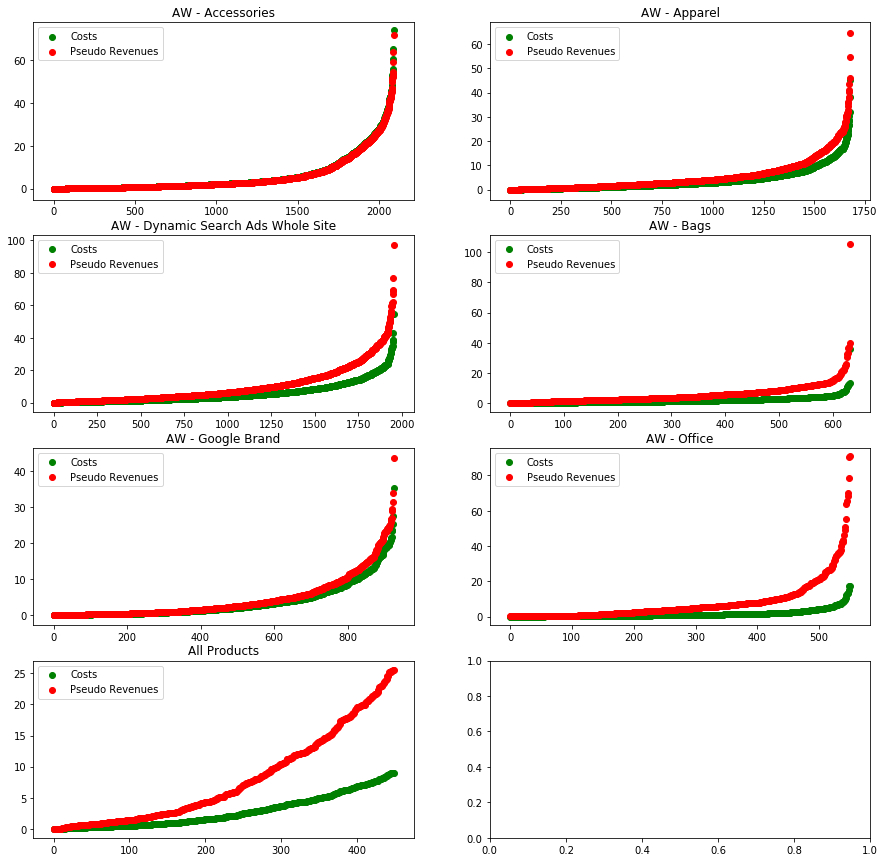

In [9]:
from ipynb.fs.defs.nb3 import scatterRevenues
scatterRevenues(LRFinalDf)

In [10]:
from ipynb.fs.defs.nb3 import getSummedPseudoRevenues
LRFinalDf = getSummedPseudoRevenues(LRFinalDf, features=["Cost"])
print(LRFinalDf.shape, LRFinalDf.columns)

(8281, 21) Index(['Date', 'Source / Medium', 'Campaign', 'Device Category', 'Users',
       'Sessions', 'Bounces', 'Transactions', 'Cost', 'Revenue',
       'Product Detail Views', 'Product Adds To Cart', 'Product Checkouts',
       'Session Duration', 'Total Unique Searches', 'Pageviews', 'New Users',
       'Session Duration (s)', 'Medium', 'Pseudo Revenue',
       'Summed Pseudo Revenue'],
      dtype='object')


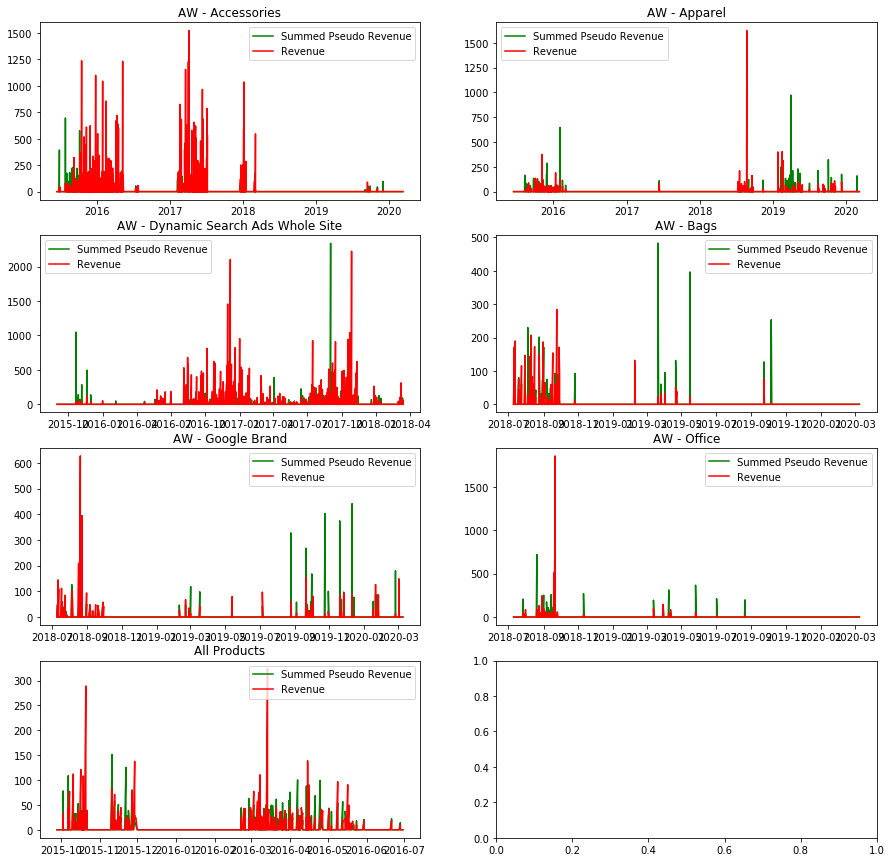

In [11]:
from ipynb.fs.defs.nb3 import plotSummedRevenues
plotSummedRevenues(LRFinalDf)

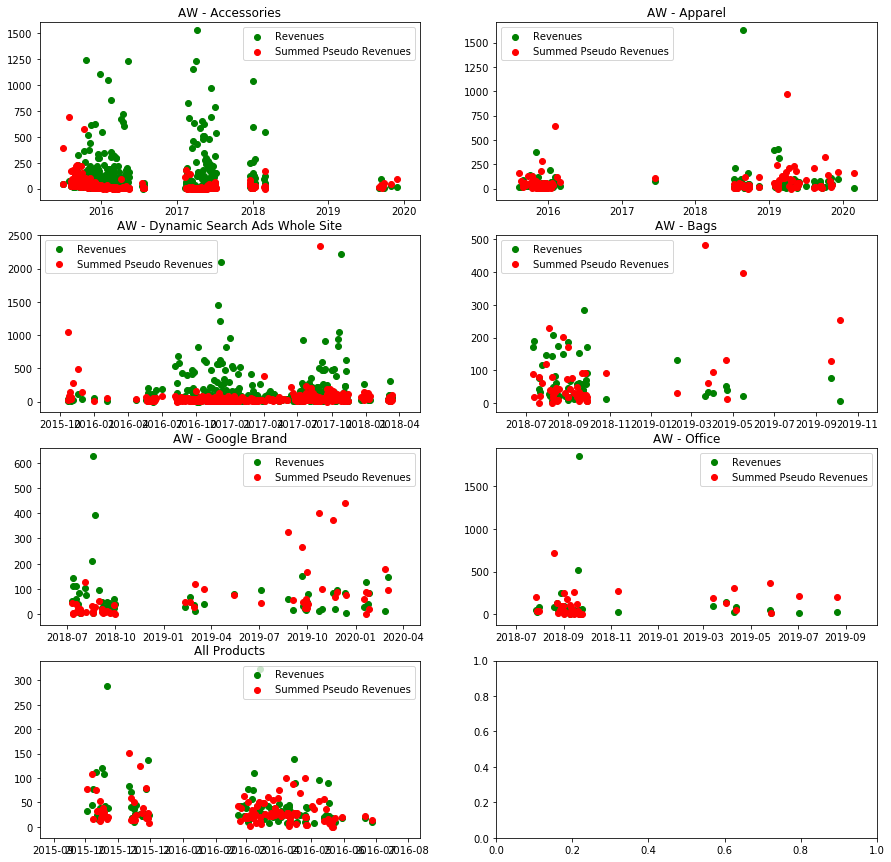

In [12]:
from ipynb.fs.defs.nb3 import scatterSummedRevenues
scatterSummedRevenues(LRFinalDf)

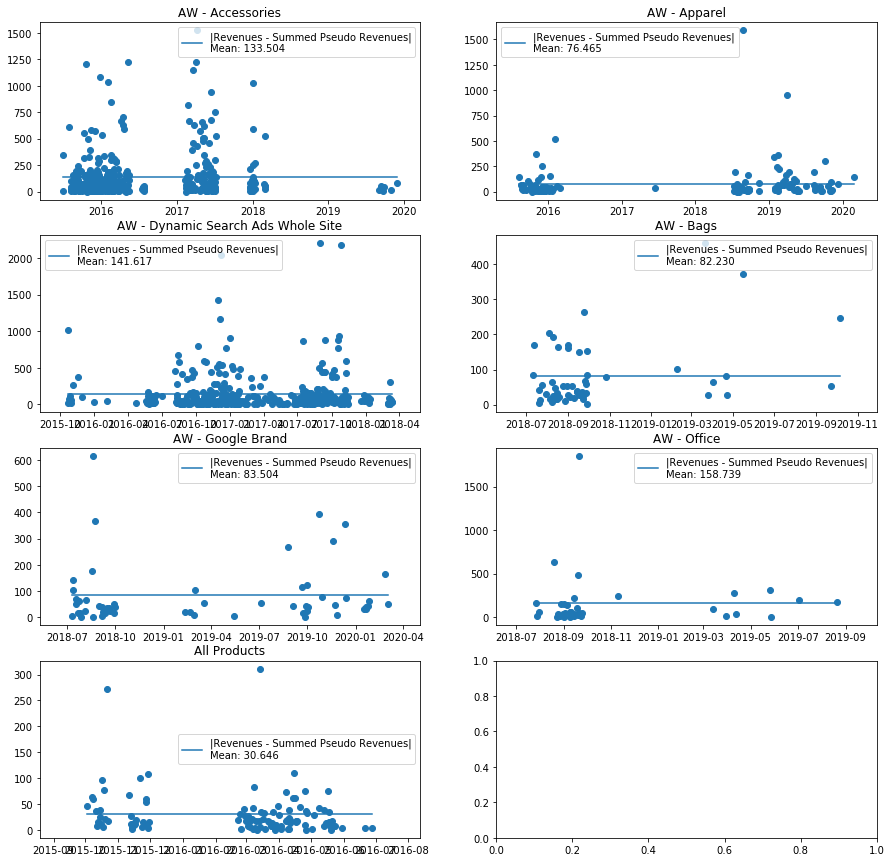

In [13]:
from ipynb.fs.defs.nb3 import scatterErrorSummedRevenues
scatterErrorSummedRevenues(LRFinalDf)

In [14]:
from ipynb.fs.defs.nb3 import getOverallError
LROverallError = getOverallError(LRFinalDf)
display(LROverallError)

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.71,4719.436513,140.930774,133.504 +/- 208.924,48.646934
1,AW - Apparel,9104.17,723.670683,65.972246,76.465 +/- 171.431,53.683411
2,AW - Bags,3721.28,482.759647,71.563077,82.230 +/- 94.144,53.467902
3,AW - Dynamic Search Ads Whole Site,57540.27,6404.421196,150.628979,141.617 +/- 265.229,48.458098
4,AW - Google Brand,4122.77,338.144580,73.620893,83.504 +/- 117.513,53.145076
5,AW - Office,4269.28,491.083729,118.591111,158.739 +/- 322.612,57.238291
6,All Products,4502.51,1314.651219,41.307431,30.646 +/- 43.937,42.591764


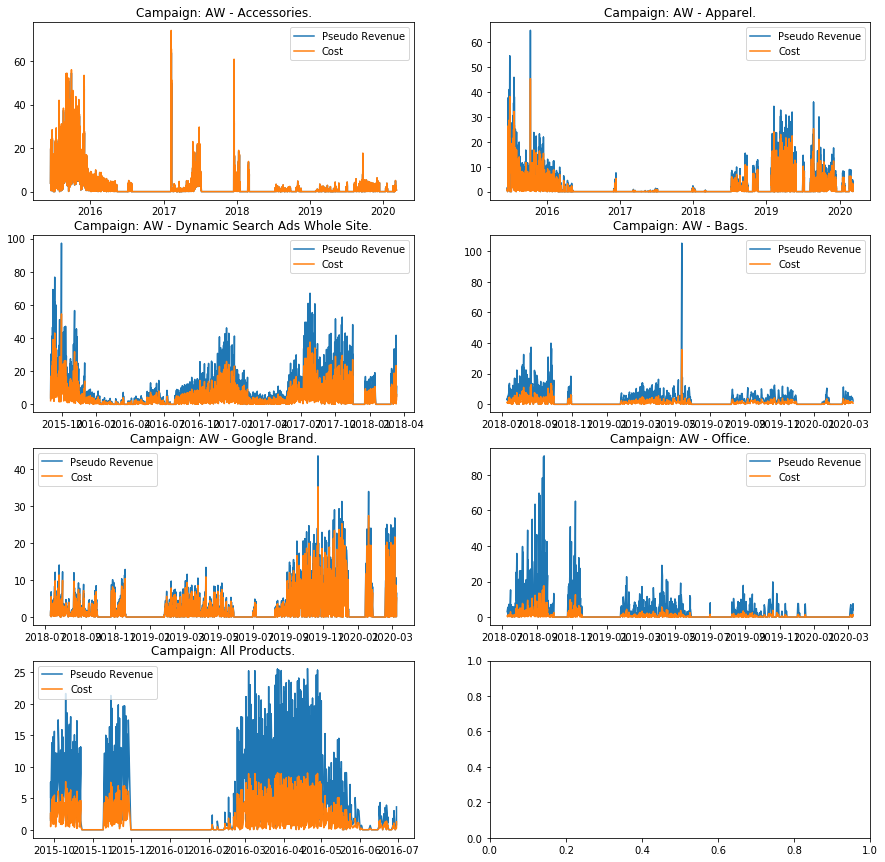

In [15]:
from ipynb.fs.defs.nb3 import plotFinalResults
plotFinalResults(LRFinalDf, LROverallError)

### 2.4 Linear regression with more features

(TODO)

#### 2.4.1 Dataset

In [16]:
features = ["Cost", "Device Category"]
validOneHotDf = pd.get_dummies(validDf[features].reset_index(drop=True))
features = validOneHotDf.columns

validOneHotDf = pd.merge(validDf[["Date", "Campaign", "Revenue"]], validOneHotDf, left_index=True, right_index=True).reset_index(drop=True)
XFeats, t = getDataFirstRevenue(validOneHotDf, features=features)

Campaign: AW - Accessories. Shapes: (452,) (452, 1) object float64
Campaign: AW - Apparel. Shapes: (138,) (138, 1) object float64
Campaign: AW - Dynamic Search Ads Whole Site. Shapes: (382,) (382, 1) object float64
Campaign: AW - Bags. Shapes: (52,) (52, 1) object float64
Campaign: AW - Google Brand. Shapes: (56,) (56, 1) object float64
Campaign: AW - Office. Shapes: (36,) (36, 1) object float64
Campaign: All Products. Shapes: (109,) (109, 1) object float64


#### 2.4.1.2 Convert columns to one-hot where possible

In [17]:
XFeatsLR, tFeatsLR, Mappings = {}, {}, {}

def getDataLR(X, t):
    Mappings, XRes, tRes = [], [], []
    N = len(X)
    for i in range(N):
        cost = X[i][:, 0]
        XRes.extend(list(X[i]))
        tRes.extend(list(t[i] / cost))
        Mappings.extend([i] * len(X[i]))
    return np.array(XRes), np.array(tRes).reshape((-1, 1)), np.array(Mappings)

for k in X:
    XFeatsNoDummy, tFeatsLR[k], Mappings[k] = getDataLR(XFeats[k], t[k])
    
    dummied = []
    numFeatures = XFeatsNoDummy.shape[-1]
    for i in range(numFeatures):
        item = XFeatsNoDummy[:, i]
        try:
            _ = item.astype(np.float32)
            item = item.reshape(-1, 1)
        except Exception as e:
            item = pd.get_dummies(item)
        dummied.append(item)
    XFeatsLR[k] = np.concatenate(dummied, axis=-1)
    print(k, XFeatsLR[k].shape)

AW - Accessories (2090, 4)
AW - Apparel (1678, 4)
AW - Dynamic Search Ads Whole Site (1954, 4)
AW - Bags (633, 4)
AW - Google Brand (926, 4)
AW - Office (551, 4)
All Products (449, 4)


In [18]:
LR = partial(LinearRegression, fit_intercept=True, normalize=True)
XXs = getOptimalThresholds(validOneHotDf, XFeatsLR, tFeatsLR, LR, columns=features, numSplits=5, randomState=42)
print(XXs)

{'AW - Accessories': 68, 'AW - Apparel': 24, 'AW - Dynamic Search Ads Whole Site': 79, 'AW - Bags': 16, 'AW - Google Brand': 12, 'AW - Office': 7, 'All Products': 39}


In [19]:
LRModels, LRErrors = trainAllCampaignsLR(validOneHotDf, XFeatsLR, tFeatsLR, LR, columns=features, XXs=XXs, numSplits=5, randomState=42)
display(pd.DataFrame([(x, y) for x, y in zip(LRErrors.keys(), LRErrors.values())], columns=["Campaign", "Best error (L1)"]))

,Campaign,Best error (L1)
0,AW - Accessories,235.710000
1,AW - Apparel,164.106408
2,AW - Dynamic Search Ads Whole Site,-259.355000
3,AW - Bags,39.768770
4,AW - Google Brand,199.828594
5,AW - Office,-37.117619
6,All Products,-56.274325


In [20]:
LRFinalDf = createPseudoRevenues(LRModels, validOneHotDf, features)
print(LRFinalDf.shape, LRFinalDf.columns)

(8281, 8) Index(['Date', 'Campaign', 'Revenue', 'Cost', 'Device Category_desktop',
       'Device Category_mobile', 'Device Category_tablet', 'Pseudo Revenue'],
      dtype='object')


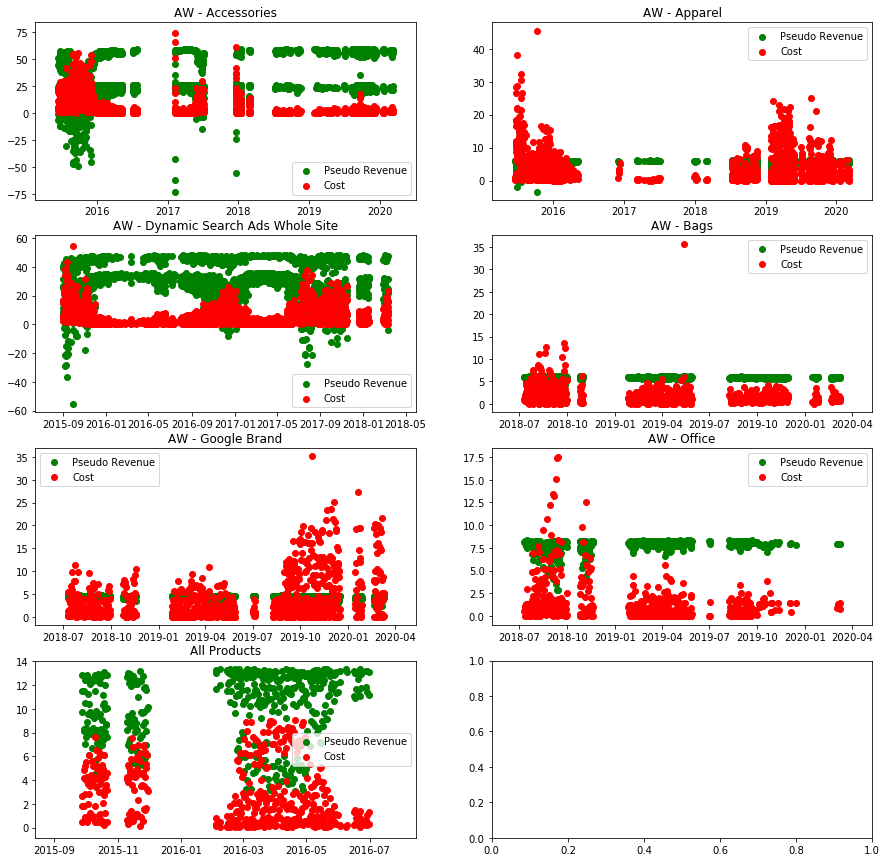

In [21]:
plotRevenues(LRFinalDf)

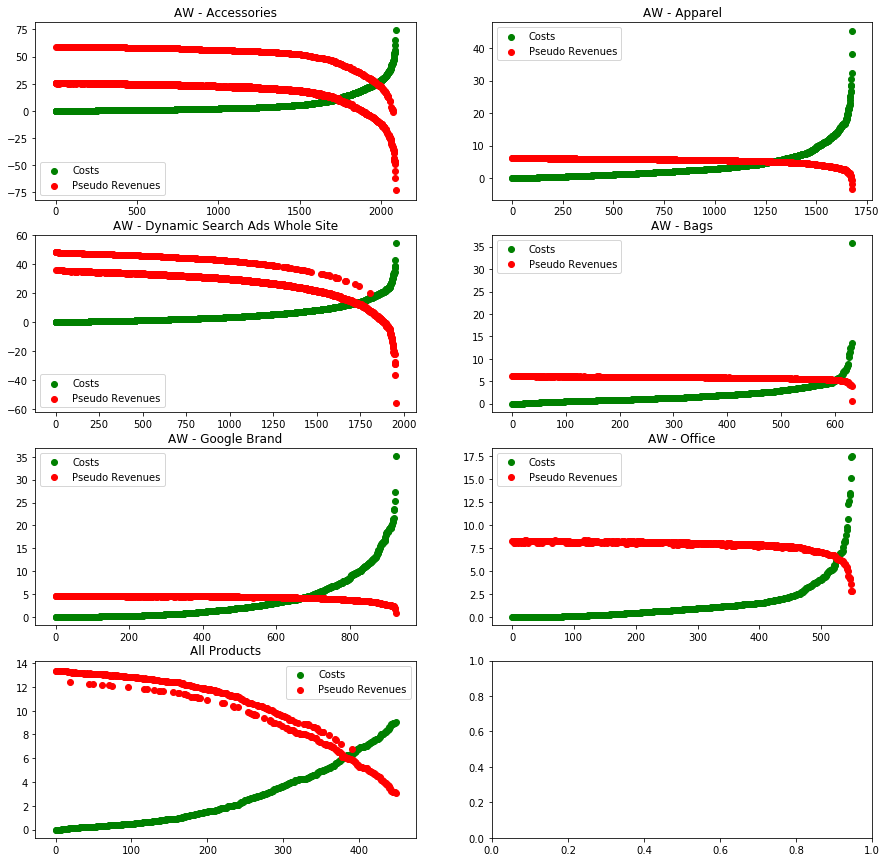

In [22]:
scatterRevenues(LRFinalDf)

In [23]:
LRFinalDf = getSummedPseudoRevenues(LRFinalDf, features=features)
print(LRFinalDf.shape, LRFinalDf.columns)

(8281, 9) Index(['Date', 'Campaign', 'Revenue', 'Cost', 'Device Category_desktop',
       'Device Category_mobile', 'Device Category_tablet', 'Pseudo Revenue',
       'Summed Pseudo Revenue'],
      dtype='object')


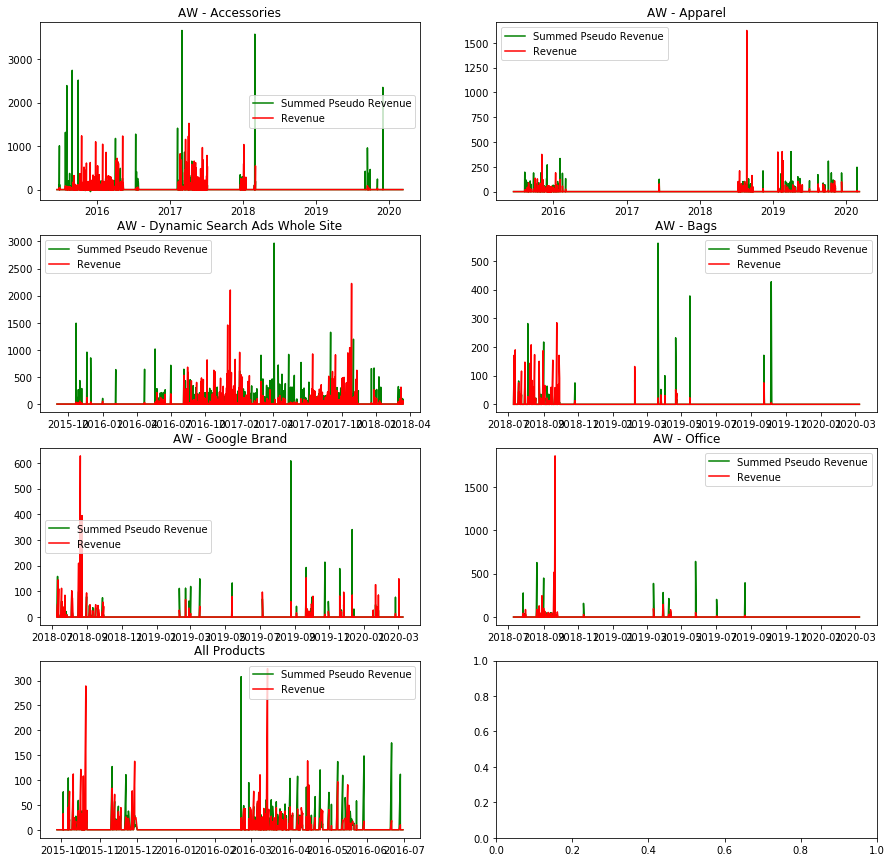

In [24]:
plotSummedRevenues(LRFinalDf)

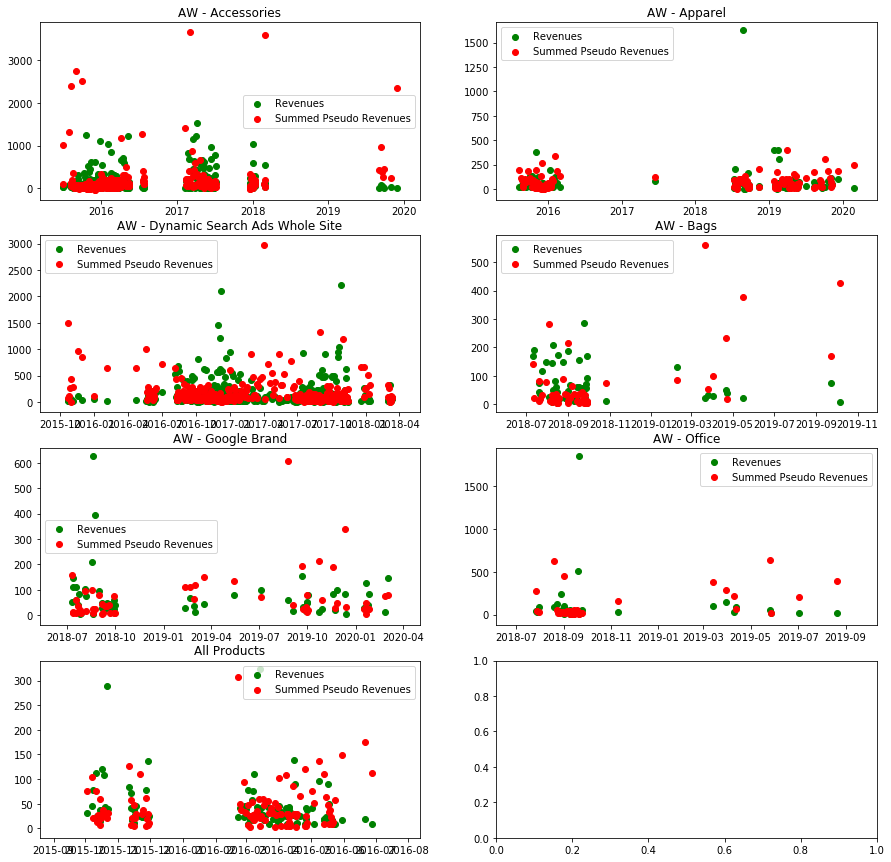

In [25]:
scatterSummedRevenues(LRFinalDf)

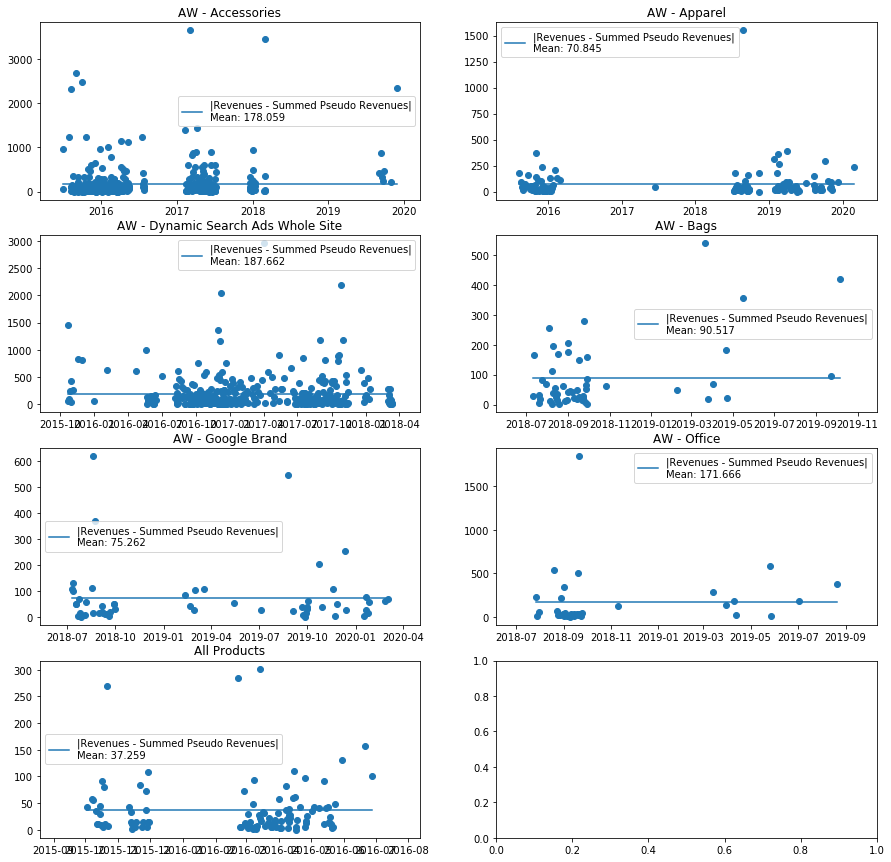

In [26]:
scatterErrorSummedRevenues(LRFinalDf)

In [27]:
LROverallError = getOverallError(LRFinalDf)
display(LROverallError)

,Campaign,Sum Revenues,Sum Pseudo Revenues,Avg Revenue,Avg Diff Error (L1),Avg Relative (%)
0,AW - Accessories,63700.71,9391.500000,140.930774,178.059 +/- 383.542,55.819615
1,AW - Apparel,9104.17,737.478766,65.972246,70.845 +/- 148.228,51.780676
2,AW - Bags,3721.28,292.492676,71.563077,90.517 +/- 112.300,55.847094
3,AW - Dynamic Search Ads Whole Site,57540.27,7830.656250,150.628979,187.662 +/- 301.820,55.473503
4,AW - Google Brand,4122.77,230.535156,73.620893,75.262 +/- 117.908,50.551107
5,AW - Office,4269.28,268.865085,118.591111,171.666 +/- 330.448,59.142754
6,All Products,4502.51,930.387592,41.307431,37.259 +/- 52.247,47.423766


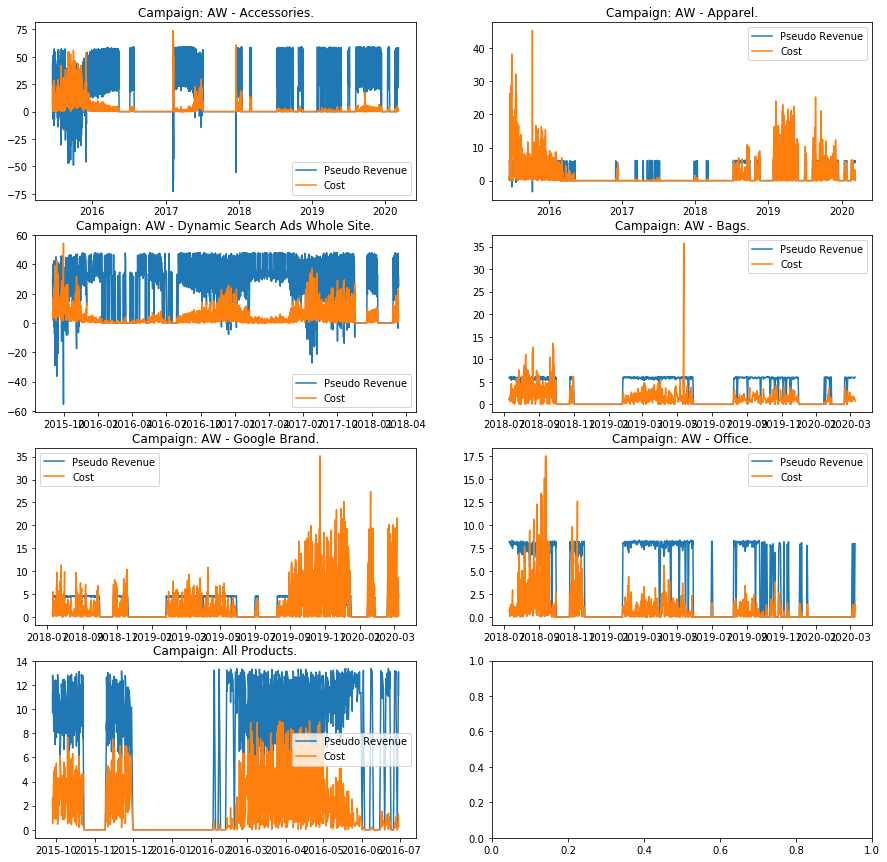

In [28]:
plotFinalResults(LRFinalDf, LROverallError)